In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.telstra_data import TelstraData

/home/daria/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Read in the data. I use a `converters` keyword argument to convert location, event, etc. strings into integers.

In [2]:
datadir = 'data'
def str_to_num(string):
    return int(string.split(" ")[1])
train = pd.read_csv(os.path.join(datadir, 'train.csv'), index_col='id', converters = {'location':str_to_num})
test = pd.read_csv(os.path.join(datadir, 'test.csv'), index_col='id', converters = {'location':str_to_num})

events = pd.read_csv(os.path.join(datadir,'event_type.csv'), converters = {'event_type':str_to_num})
log = pd.read_csv(os.path.join(datadir,'log_feature.csv'), converters = {'log_feature':str_to_num})
resource = pd.read_csv(os.path.join(datadir,'resource_type.csv'), converters = {'resource_type':str_to_num})
sev = pd.read_csv(os.path.join(datadir,'severity_type.csv'), index_col = 'id',converters = {'severity_type':str_to_num})

Join train and test and create a visualisation of data using location, id and fault_severity columns.

fault_severity encoded by color: red for 2, blue for 1, green for 0. Test samples are tiny black dots.

In [3]:
df = train.append(test)

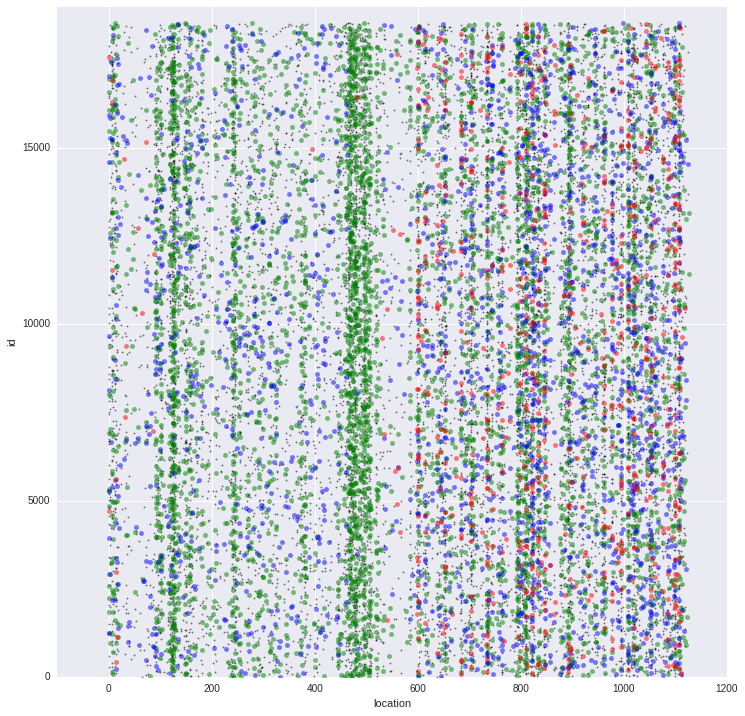

In [4]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(df.loc[df.fault_severity.isnull(),'location'],df.loc[df.fault_severity.isnull()].index,alpha=0.5,color='k',s=2)
ax.scatter(df.loc[df.fault_severity==0,'location'],df.loc[df.fault_severity==0].index,alpha=0.5,color='g')
ax.scatter(df.loc[df.fault_severity==1,'location'],df.loc[df.fault_severity==1].index,alpha=0.5,color='b')
ax.scatter(df.loc[df.fault_severity==2,'location'],df.loc[df.fault_severity==2].index,alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((0,19000))
ax.set_xlabel('location')
ax.set_ylabel('id');

We can see that location is going to be an important feature. But as to id I can't see any patterns.

Then we spend some time exploring the dataset and decide to look at the relationships between variables. Since both locations and severity_types are 1:1 related to ids, we might as well start with them.

Let's add fault_severity and location columns to the sev dataframe. 

In [5]:
sev[df.columns] = df
sev.head()

,severity_type,fault_severity,location
id,,,
6597,2,NaN,1
8011,2,0,1
2597,2,NaN,1
5022,1,NaN,1
6852,1,NaN,1


Hey, why does the location column only have ones?

What is the tail of sev now?

In [6]:
sev.tail(10)

,severity_type,fault_severity,location
id,,,
1989,1,NaN,999
15206,1,NaN,999
15084,1,NaN,999
8114,2,0,999
8955,1,NaN,999
3761,1,NaN,999
8720,1,NaN,999
6488,2,NaN,999
878,2,0,999


Wow, looks like the locations are sorted here. Well, if the rows are sorted by location, maybe they're also sorted by time. Let's try numbering rows inside each location group.

In [7]:
sev['num'] = sev.groupby('location')['fault_severity'].transform(lambda x: np.arange(x.shape[0])+1)
sev.head()

,severity_type,fault_severity,location,num
id,,,,
6597,2,NaN,1,1
8011,2,0,1,2
2597,2,NaN,1,3
5022,1,NaN,1,4
6852,1,NaN,1,5


This will produce the same result with a built-in pandas function.

In [8]:
sev['num'] = sev.groupby('location').cumcount() + 1

See a histogram of new feature

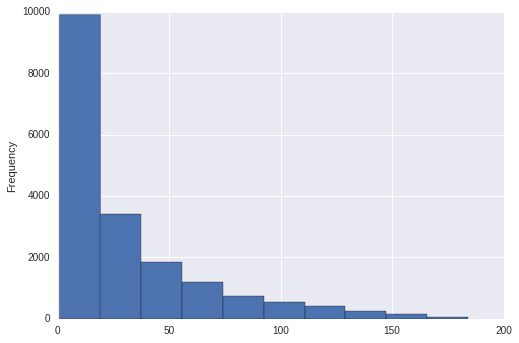

In [9]:
sev['num'].plot(kind='hist')

Let's plot a scatterplot of num and location coloring the samples by class.

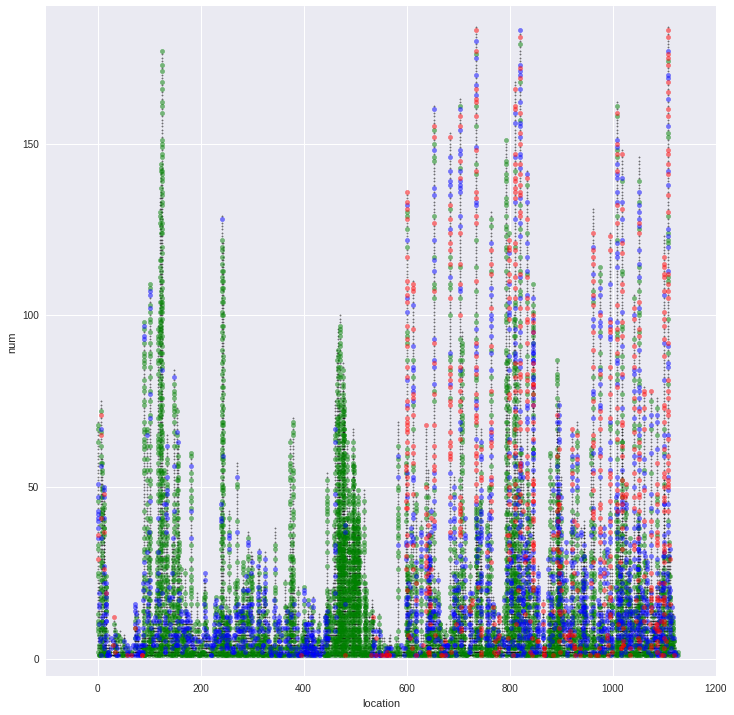

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(sev.loc[sev.fault_severity.isnull(),'location'],sev.loc[sev.fault_severity.isnull(),'num'],alpha=0.5,color='k',s=2)
ax.scatter(sev.loc[sev.fault_severity==0,'location'],sev.loc[sev.fault_severity==0,'num'],alpha=0.5,color='g')
ax.scatter(sev.loc[sev.fault_severity==1,'location'],sev.loc[sev.fault_severity==1,'num'],alpha=0.5,color='b')
ax.scatter(sev.loc[sev.fault_severity==2,'location'],sev.loc[sev.fault_severity==2,'num'],alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((-5,190))
ax.set_xlabel('location')
ax.set_ylabel('num');

@Jared Turkewitz suggested on the forums also using the reversed numbering of locations. Let's try that.

In [11]:
sev['revnum'] = sev.groupby('location')['num'].transform(lambda x: x.max() + 1 - x)
sev.head()

,severity_type,fault_severity,location,num,revnum
id,,,,,
6597,2,NaN,1,1,69
8011,2,0,1,2,68
2597,2,NaN,1,3,67
5022,1,NaN,1,4,66
6852,1,NaN,1,5,65


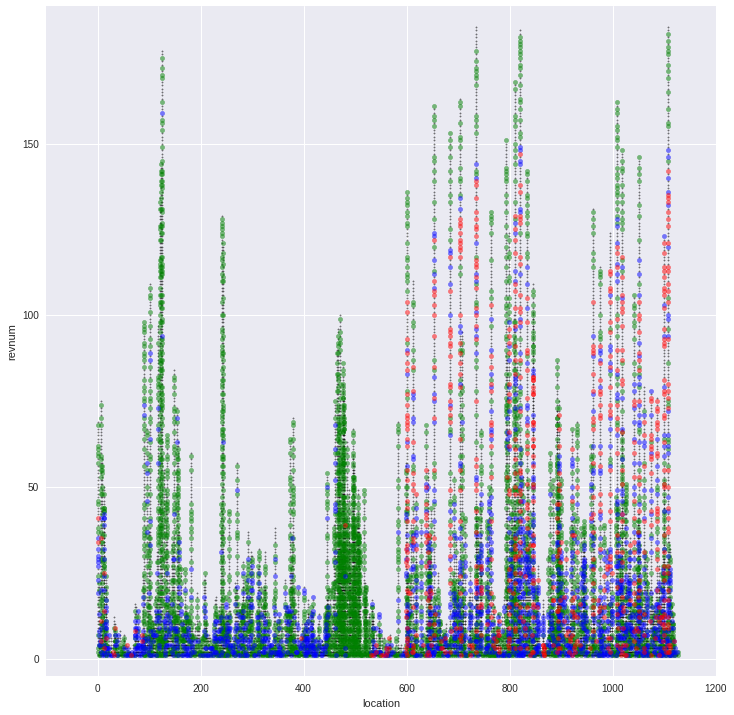

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(sev.loc[sev.fault_severity.isnull(),'location'],sev.loc[sev.fault_severity.isnull(),'revnum'],alpha=0.5,color='k',s=2)
ax.scatter(sev.loc[sev.fault_severity==0,'location'],sev.loc[sev.fault_severity==0,'revnum'],alpha=0.5,color='g')
ax.scatter(sev.loc[sev.fault_severity==1,'location'],sev.loc[sev.fault_severity==1,'revnum'],alpha=0.5,color='b')
ax.scatter(sev.loc[sev.fault_severity==2,'location'],sev.loc[sev.fault_severity==2,'revnum'],alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((-5,190))
ax.set_xlabel('location')
ax.set_ylabel('revnum');

Do you notice how the tops of long columns on the right suddenly became all green? It wasn't visible on the previous plot.

Let's try normalizing the count within each location. There are multiple ways to do it, I find this one looks best on plots.

In [13]:
sev['numsh'] = sev.groupby('location')['num'].apply(lambda x: x / (x.max() + 1))
sev.head()

,severity_type,fault_severity,location,num,revnum,numsh
id,,,,,,
6597,2,NaN,1,1,69,0.014286
8011,2,0,1,2,68,0.028571
2597,2,NaN,1,3,67,0.042857
5022,1,NaN,1,4,66,0.057143
6852,1,NaN,1,5,65,0.071429


Let's plot the normalized counts scatterplot.

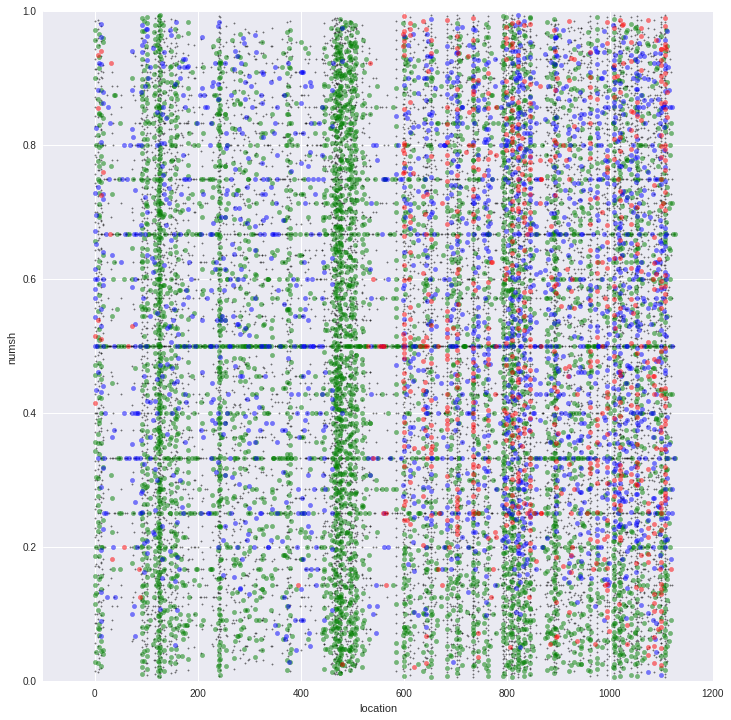

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(sev.loc[sev.fault_severity.isnull(),'location'],sev.loc[sev.fault_severity.isnull(),'numsh'],alpha=0.5,color='k',s=2)
ax.scatter(sev.loc[sev.fault_severity==0,'location'],sev.loc[sev.fault_severity==0,'numsh'],alpha=0.5,color='g')
ax.scatter(sev.loc[sev.fault_severity==1,'location'],sev.loc[sev.fault_severity==1,'numsh'],alpha=0.5,color='b')
ax.scatter(sev.loc[sev.fault_severity==2,'location'],sev.loc[sev.fault_severity==2,'numsh'],alpha=0.5,color='r')
ax.set_xlim((-100,1200))
ax.set_ylim((0,1))
ax.set_xlabel('location')
ax.set_ylabel('numsh');

Here too we can see how the lower portion of data for locations > 600 is mostly green.

Let's try plotting fault_severity vs. time for some locations.

In [15]:
common_locs = sev.location.value_counts().index[:20]

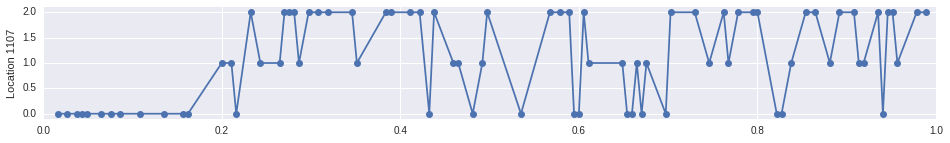

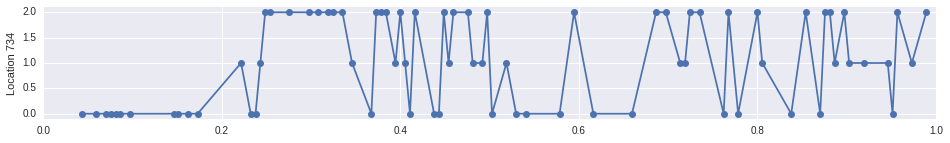

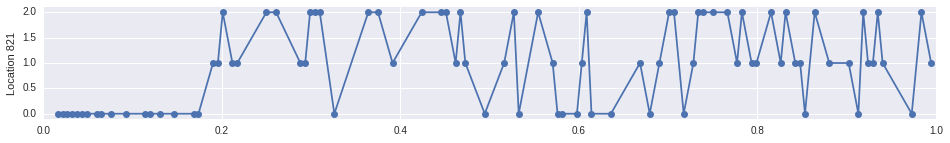

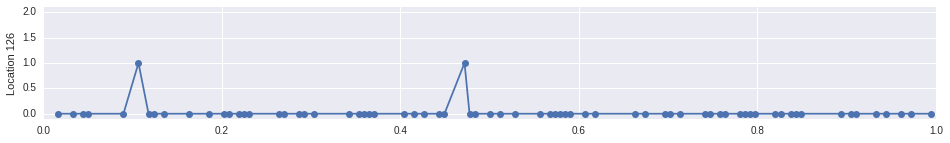

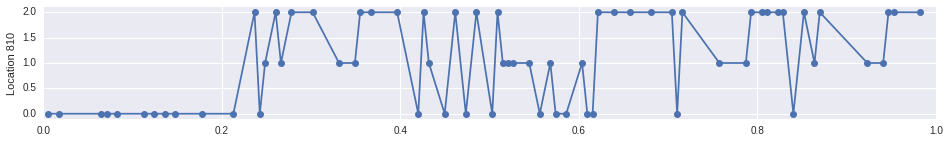

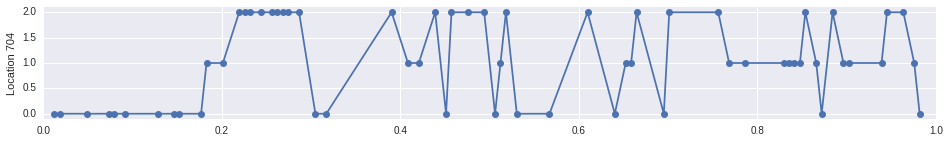

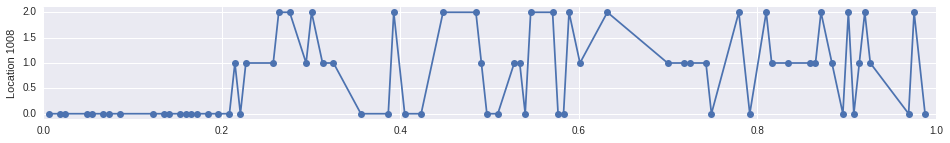

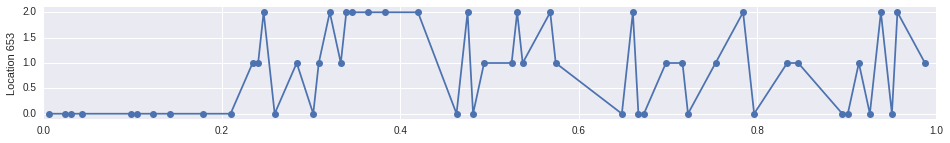

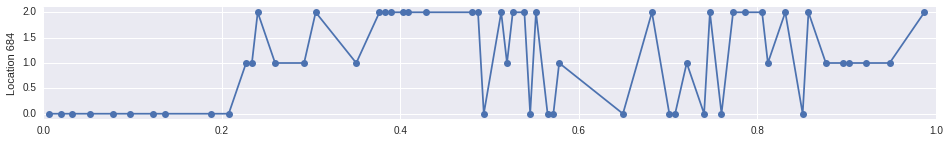

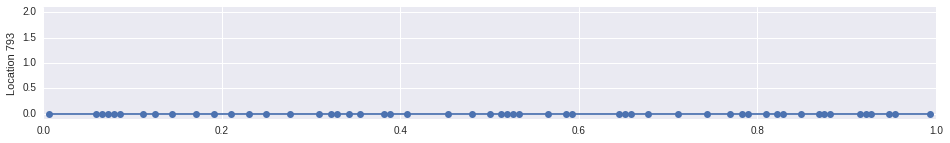

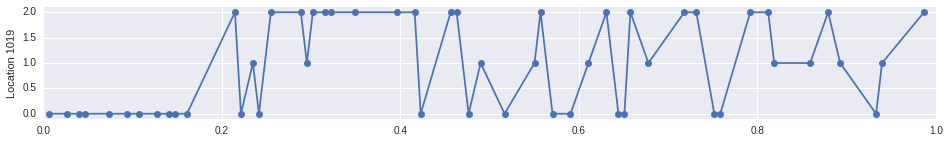

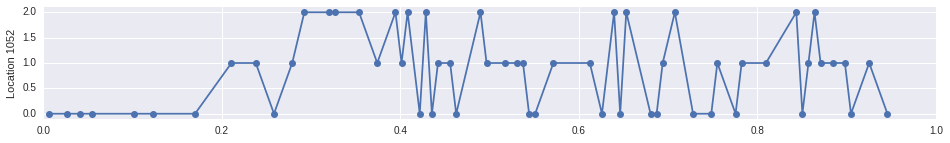

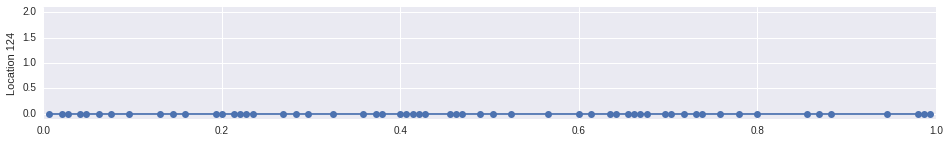

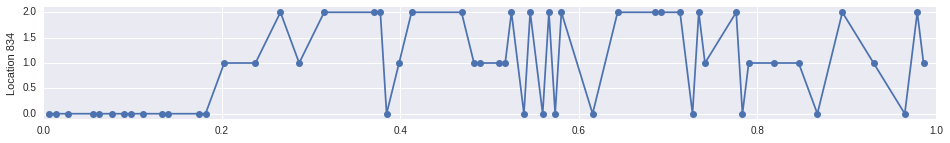

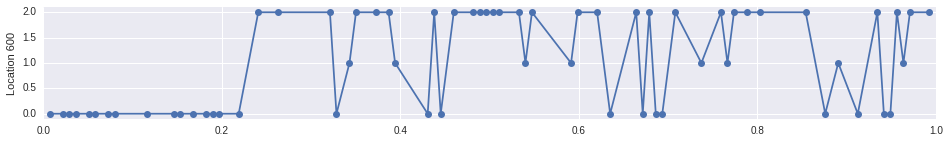

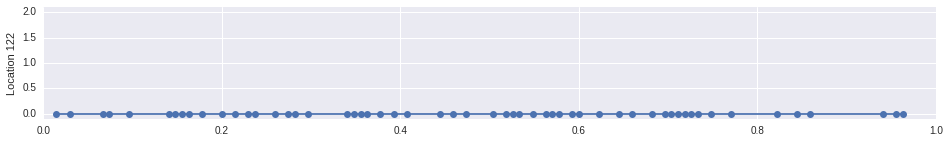

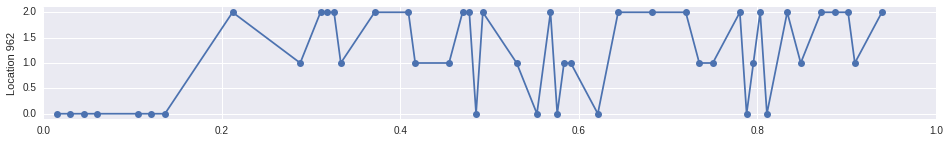

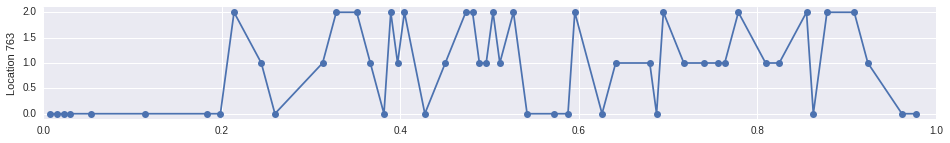

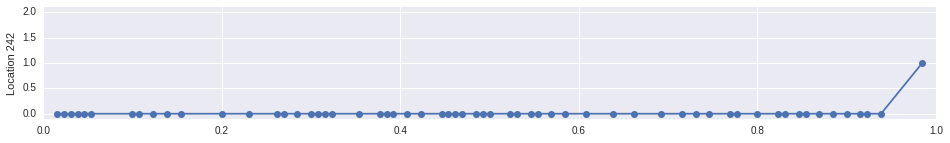

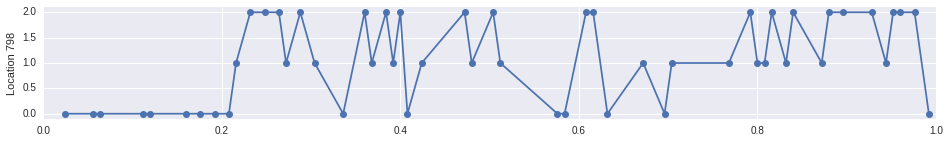

In [16]:
for l in common_locs:
    fig,ax = plt.subplots(figsize=(16,2))
    ldf = sev.loc[sev.location==l].dropna()
    ax.plot(ldf.numsh, ldf.fault_severity,'-o')
    ax.set_ylim(-0.1,2.1)
    ax.set_ylabel("Location {}".format(l))

Here we can again see how rare fault_severities other than 0 are when normalized time is < 0.2. Can you spot any other patterns?

I'll show one more visualisation we can use for plotting some features at a location over time. I'll load the data to have some features defined.

In [17]:
data = TelstraData()
X = data.X
X.fault_severity = data.data['train'].fault_severity

In [18]:
def plot_loc_feature(location, feature, ax=None):
    if ax is None:
        fig, ax= plt.subplots()
    loc = X.loc[X.location==location,['fault_severity','numsh',feature]]
    ax.plot(loc['numsh'],loc[feature],'-')
    ax.plot(loc.loc[loc.fault_severity==0,'numsh'], loc.loc[loc.fault_severity==0,feature],'go')
    ax.plot(loc.loc[loc.fault_severity==1,'numsh'], loc.loc[loc.fault_severity==1,feature],'bo')
    ax.plot(loc.loc[loc.fault_severity==2,'numsh'], loc.loc[loc.fault_severity==2,feature],'ro')
    ax.plot(loc.loc[loc.fault_severity.isnull(),'numsh'], loc.loc[loc.fault_severity.isnull(),feature],'ko',alpha=0.4)
    ax.set_title('{} at location {}'.format(feature, location))

Let's look for example at volume of log feature 203, which seems to be a variable of high importance. The volume is transformed by np.log(1+x).

Color of dots indicates fault_severity as before.

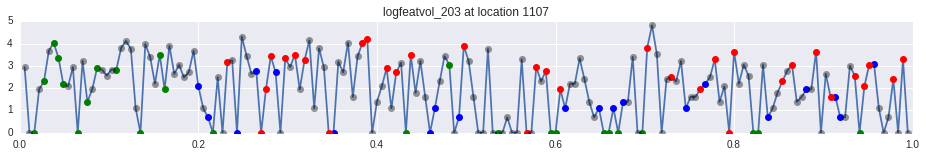

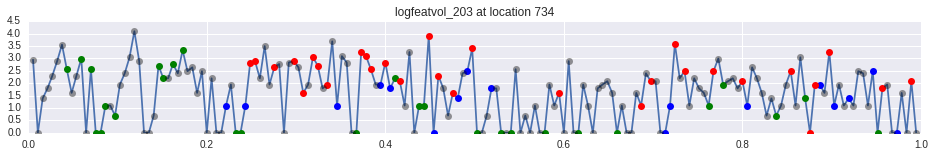

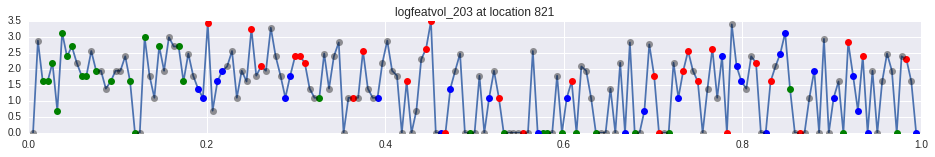

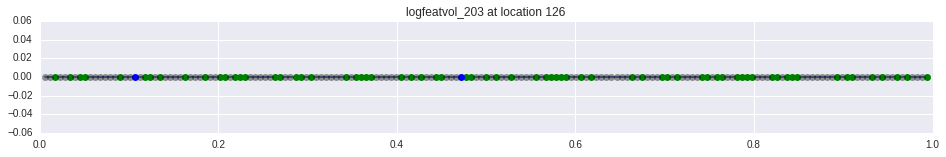

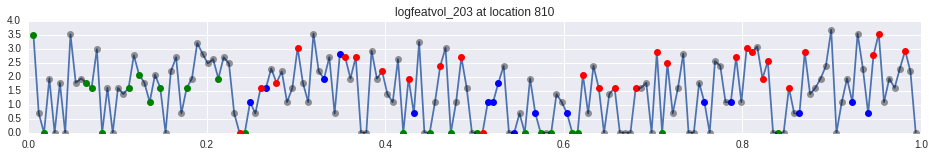

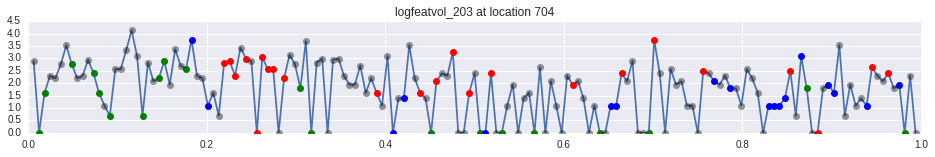

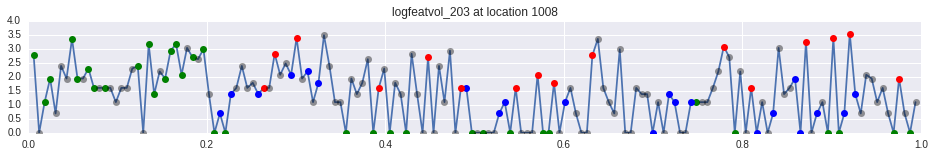

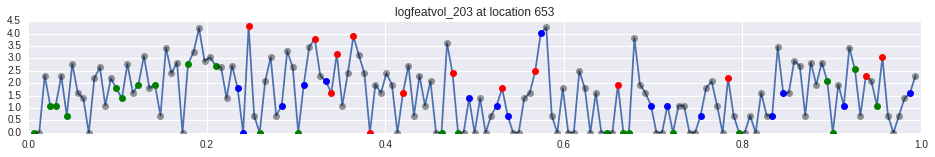

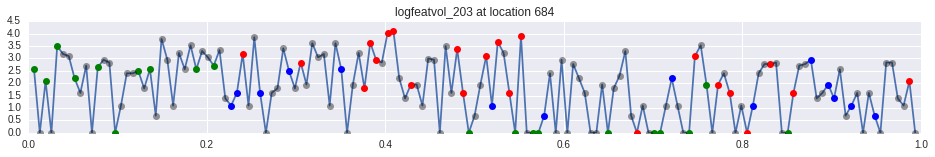

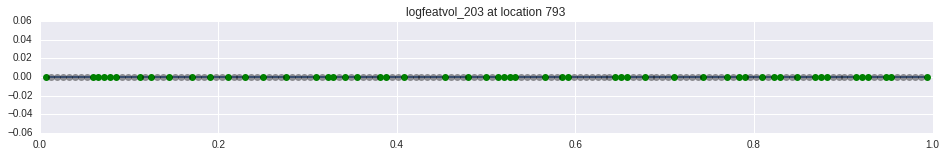

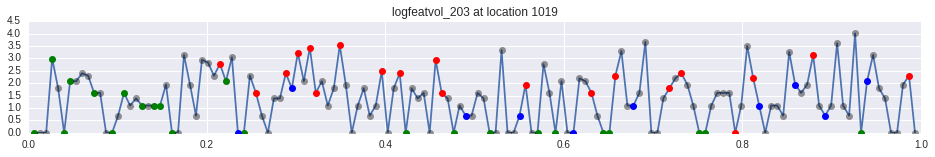

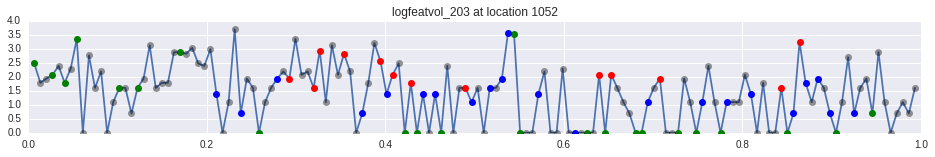

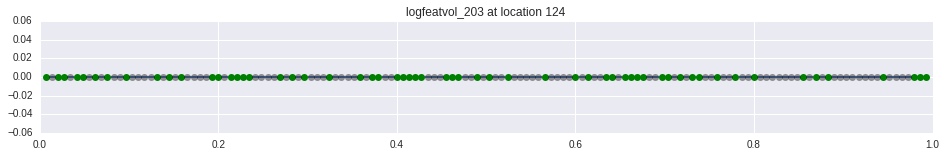

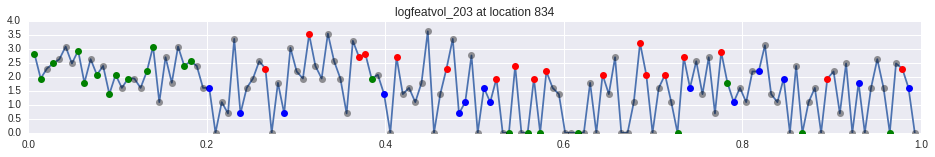

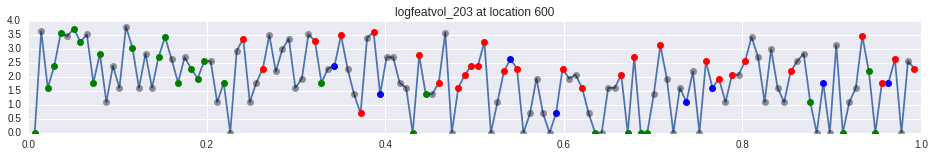

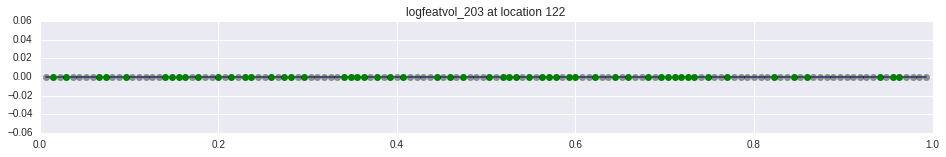

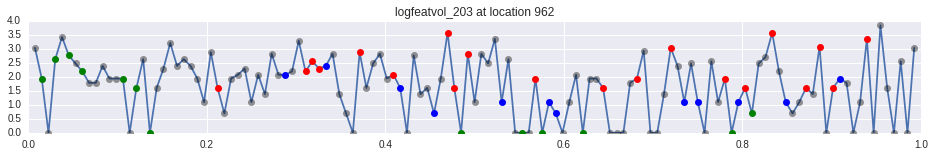

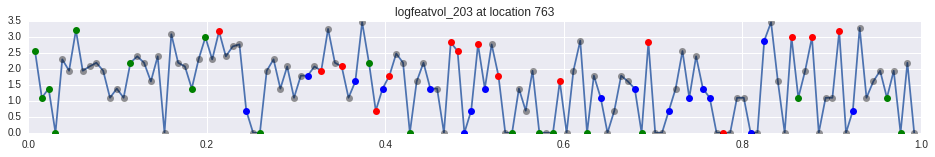

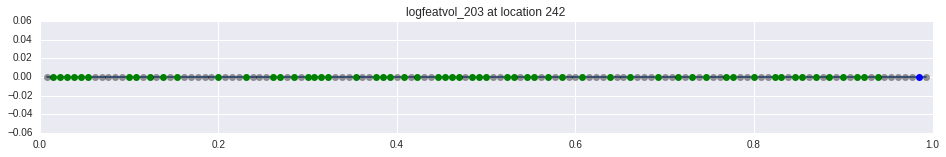

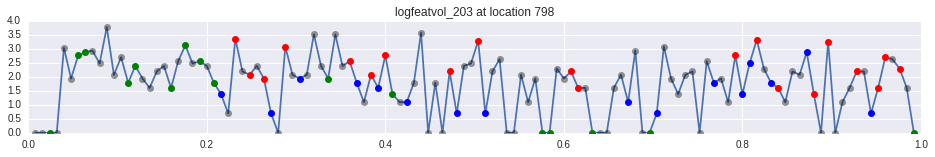

In [19]:
for l in common_locs:
    fig,ax = plt.subplots(figsize=(16,2))
    plot_loc_feature(l, 'logfeatvol_203',ax=ax)